This notebook is to extract all the static embedding (no fine tuning) from the different LLMs.

-> You can use this one to explore how prompting change the embedding for the LLM and use other models to extract embedding.

In [7]:
import os
import pandas as pd
import numpy as np

In [8]:
assert os.path.isfile('data/TGCA_Merged.csv'), 'Execute 0. Extraction.ipynb'

In [9]:
report = pd.read_csv('data/TGCA_Merged.csv', index_col = 0)
report.head()

,text,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,e,t,Hospital,grouping
TCGA-BP-5195,Date of Recelpt: Clinical Diagnosis & History:...,KIRC,75.0,True,True,1.0,0.0,749.0,mskcc,Genitourinary
TCGA-D7-8573,"Material: 1) Material: stomach, Method of coll...",STAD,57.0,True,True,2.0,0.0,593.0,greater poland cancer center,Gastrointestinal
TCGA-EI-7004,page 1 / 1. copy No. 3. Examination: Histopath...,READ,37.0,False,True,NaN,0.0,257.0,greater poland cancer center,Gastrointestinal
TCGA-EB-A82B,Patient ID: Gross Description: A mass is locat...,SKCM,58.0,False,False,3.0,0.0,390.0,asterand,Skin
TCGA-A6-3808,SPECIMEN. Right colon. CLINICAL NOTES. PRE-OP ...,COAD,73.0,True,True,2.0,0.0,1014.0,christiana healthcare,Gastrointestinal


### ChatGPT embedding

In [ ]:
os.environ['OPENAI_API_KEY'] = open('KEY.txt', 'r').readline()

In [ ]:
from openai import OpenAI
client = OpenAI()

In [ ]:
assert False, "Are you sure you wanna run? $$$"
def get_embedding(text, model="text-embedding-ada-002"):
   return client.embeddings.create(input = [text], model = model).data[0].embedding

report_gpt = pd.DataFrame(report.text.apply(lambda x: get_embedding(x)).tolist(), index = report.index)
report_gpt.to_csv('data/gpt_embedding.csv')

### Bio Clinical BERT

In [4]:
def get_embedding(text, tokenizer, model):
   inputs = tokenizer(text, return_tensors="pt", truncation = True, max_length = 512)
   return model(**inputs).pooler_output.mean(0).detach().numpy()

In [5]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", output_attentions=True)

In [10]:
inputs = tokenizer(report.iloc[0].text, return_tensors="pt", truncation = True, max_length = 512)
output = model(**inputs)

In [ ]:
assert False, "Are you sure you wanna run? ~80 min"
report_clinicalBERT = pd.DataFrame(report.text.apply(lambda x: get_embedding(x, tokenizer, model)).tolist(), index = report.index)
report_clinicalBERT.to_csv('data/clinicalBERT_embedding.csv')

### BERT

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
assert False, "Are you sure you wanna run? ~80 min"
report_BERT = pd.DataFrame(report.text.apply(lambda x: get_embedding(x, tokenizer, model)).tolist(), index = report.patient_filename)
report_BERT.to_csv('data/BERT_embedding.csv')

### Visualisation

In [3]:
from sklearn import manifold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
embedding = pd.read_csv('data/binary_embedding.csv', index_col = 0)
outcomes = pd.read_csv('data/subselection.csv', index_col = 0)
embedding = (embedding - embedding.mean()) / embedding.std()

In [6]:
outcomes = outcomes.loc[outcomes.type.dropna().index]
embedding = embedding.loc[outcomes.index]

In [7]:
t_sne = manifold.TSNE(n_components = 2, random_state = 42)
embed_tsne = t_sne.fit_transform(embedding)

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(-100.0, 100.0)

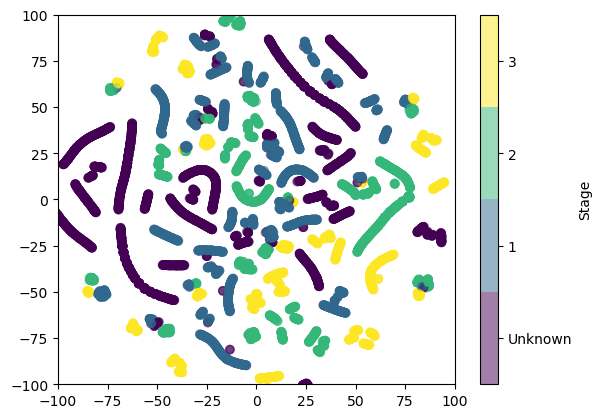

In [8]:
cmap = plt.get_cmap('viridis', 4)
plt.scatter(embed_tsne[:, 0], embed_tsne[:, 1], c = outcomes.ajcc_pathologic_tumor_stage.fillna(0), cmap = cmap, alpha = 0.5)
cbar = plt.colorbar(label = "Stage")
cbar.ax.set_yticks(0.75 * (np.arange(4) + 0.5), ['Unknown', 1, 2, 3])
plt.xlim(-100, 100)
plt.ylim(-100, 100)

(-100.0, 100.0)

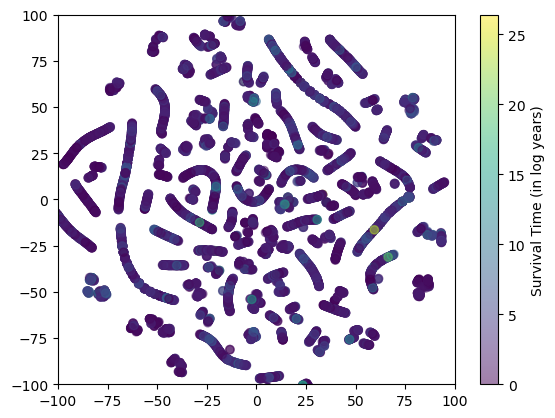

In [9]:
plt.scatter(embed_tsne[:, 0], embed_tsne[:, 1], c = outcomes.t / 365., cmap = 'viridis', alpha = 0.5)
plt.colorbar(label = "Survival Time (in log years)")
plt.xlim(-100, 100)
plt.ylim(-100, 100)

(-100.0, 100.0)

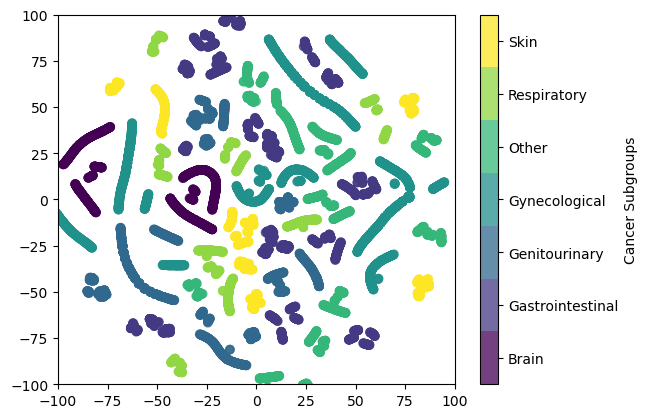

In [10]:
grouping = outcomes.grouping.astype('category').cat
length = len(grouping.categories)
cmap = plt.get_cmap('viridis', length)
plt.scatter(embed_tsne[:, 0], embed_tsne[:, 1], c = grouping.codes, cmap = cmap, alpha = 0.75)
cbar = plt.colorbar(label = "Cancer Subgroups", ticks = np.arange(length))
cbar.ax.set_yticks( (length - 1) / length * (np.arange(length) + 0.5), grouping.categories)
plt.xlim(-100, 100)
plt.ylim(-100, 100)

In [11]:
embed_tsne = embed_tsne[outcomes.grouping == "Gynecological"]
embedding = embedding[outcomes.grouping == "Gynecological"]
outcomes = outcomes[outcomes.grouping == "Gynecological"]

(-100.0, 100.0)

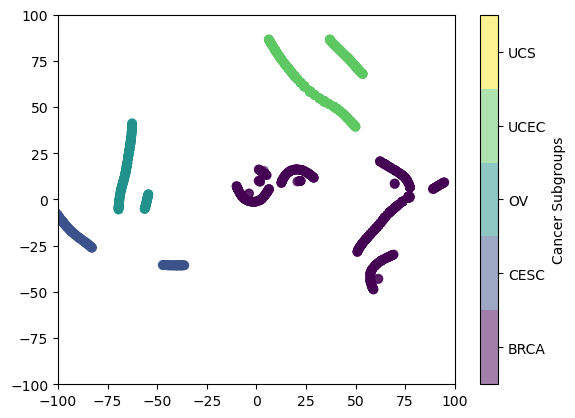

In [12]:
length = len(outcomes.type.astype('category').cat.categories)
cmap = plt.get_cmap('viridis', length)
plt.scatter(embed_tsne[:, 0], embed_tsne[:, 1], c = outcomes.loc[embedding.index].type.astype('category').cat.codes, cmap = cmap, alpha = 0.5)
cbar = plt.colorbar(label = "Cancer Subgroups", ticks = np.arange(length))
cbar.ax.set_yticks( (length - 1) / length *(np.arange(length) + 0.5), outcomes.type.astype('category').cat.categories)
plt.xlim(-100, 100)
plt.ylim(-100, 100)